# Hashtag Culture Analysis

A hashtag (#) is a type of metadata tag used on social networks such as Twitter and other microblogging services. It lets users apply dynamic, user-generated tagging that helps other users easily find messages with a specific theme or content. We can borrow some basic principles from Network Science and graph theory to understand how hashtags on Instagram are connected.

# What aspects of Graph Theory can we use in our analysis?
<ul>
    <li><b>Community Detection</b>: We can use algorithms to identify and label clusters of topics/themes</li>
    <li><b>Degree Centrality/ Betweenness Centrality</b>: We can calculate what hashtags in the network are particularly important in linking the whole network.</li>
    <li><b>Visualization</b>: If we plot the network using scatterplots, it’s a very compelling way to visualise a huge amount of information about hashtags that would be cumbersome to do otherwise</li>
</ul>
    

In [38]:
import pandas as pd
import numpy as np
import time
import networkx as nx
from node2vec import Node2Vec
import plotly.express as px
from sklearn.cluster import KMeans
from kneed import KneeLocator
from instaloader import Instaloader, Post
from sklearn.manifold import TSNE

In [3]:
hashtag_cooccurence_df = pd.read_csv("../data/instagram_hashtag_posts.csv")

In [4]:
# Drop rows with null values
hashtag_cooccurence_df = hashtag_cooccurence_df[hashtag_cooccurence_df['hashtags'].notna()]
hashtag_cooccurence_df.head()

,Unnamed: 0,post_url,hashtags
0,0,https://www.instagram.com/p/CQ--UmMH_i8/,"#sgfood, #sg, #sgfoodies, #hawkerculturesg, #k..."
1,1,https://www.instagram.com/p/CUhn24DKP0A/,"#lino, #linocutprint, #linocut, #linoprint, #l..."
2,2,https://www.instagram.com/p/CNUz7jPnpJK/,"#chinhogaixiao, #chinhojiak, #甄好吃, #甄好介绍, #sup..."
3,3,https://www.instagram.com/p/CZlBMnEPFcy/,"#hawkerculturesg, #coffeeshopsg"
4,4,https://www.instagram.com/p/COcNod6nOhv/,"#affordable, #awesomefood, #delicious, #explor..."


## Get number of likes per post

In [ ]:
loader = Instaloader()
loader.login("IS434.G1T5@gmail.com", "IS434@g1t5")  

In [29]:
post_likes_dict = {}
for index,row in hashtag_cooccurence_df.iterrows():
    try:
        shortcode = row["post_url"].split("/")[-2]
        post = Post.from_shortcode(loader.context, shortcode)
        likes = post.likes
        post_likes_dict[row["post_url"]] = likes
        time.sleep(5)
        if index%10==0:
            print(index)
    except:
        time.sleep(5)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
280
290
300
310
320


## Get average likes per hashtag

In [31]:
hashtag_occurence_dict = {}
hashtag_likes_dict = {}

for _,row in hashtag_cooccurence_df.iterrows():
    row_likes = post_likes_dict[row["post_url"]]
    hashtags_list = row["hashtags"].split(", ")
    for hashtag in hashtags_list:
        if hashtag=="Error":
            pass
        else:
            if hashtag not in hashtag_occurence_dict:
                hashtag_occurence_dict[hashtag] = 1
            else:
                hashtag_occurence_dict[hashtag] += 1
                
            if hashtag not in hashtag_likes_dict:
                hashtag_likes_dict[hashtag] = row_likes
            else:
                hashtag_likes_dict[hashtag] += row_likes

In [32]:
hashtag_avg_likes_dict = {}

In [33]:
for hashtag in hashtag_occurence_dict:
    hashtag_avg_likes_dict[hashtag] = hashtag_likes_dict[hashtag]/hashtag_occurence_dict[hashtag]

## Distribution of likes

In [40]:
hashtag_list = list(hashtag_avg_likes_dict.keys())
hashtag_avg_likes = list(hashtag_avg_likes_dict.values())

likes_distribution_df = pd.DataFrame()
likes_distribution_df["hashtags"] = hashtag_list
likes_distribution_df["average_likes"] = hashtag_avg_likes
likes_distribution_df= likes_distribution_df.sort_values(by=['average_likes'])

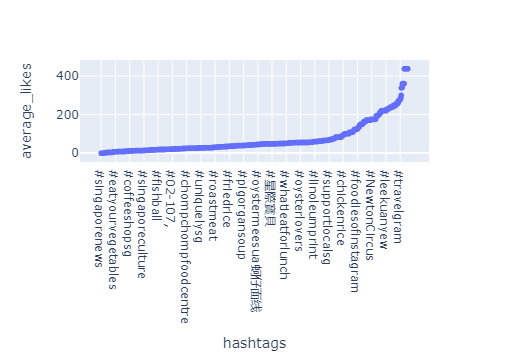

In [41]:
fig = px.scatter(likes_distribution_df, x="hashtags", y="average_likes")
fig.show()

## Create adjacency matrix

In [42]:
occurence = hashtag_cooccurence_df["hashtags"].tolist()

In [43]:
# Create set of all unique hashtags

unique_hashtags = set()
for combination in occurence:
    combination = combination.split(", ")
    for hashtag in combination:
        unique_hashtags.add(hashtag)

In [44]:
unique_hashtags = list(unique_hashtags)
unique_hashtags

['#grateful',
 '#01-27,',
 '#refuseplastic',
 '#吃货最棒',
 '#trending',
 '#printstudio',
 '#igfood',
 '#porridgesg',
 '#japanesefood',
 '#sgblogger',
 '#',
 '#simpangbedok',
 '#stjohnisland',
 '#chefkin',
 '#shiok',
 '#besurprised',
 '#红龟粿',
 '#meihueats',
 '#travelsketching',
 '#sghawkerfood',
 '#hawkercentresg',
 '#yummylunch',
 '#lifestories',
 '#usksg',
 '#好吃',
 '#angmokiolohmeelaksa',
 '#umami',
 '#nomsh',
 '#victorfamousfriedchickenwingrice',
 '#sghome',
 '#SgHeritageFood',
 '#nasilemakayamtaliwang',
 '#01-02,',
 '#cafefood',
 '#oystermeesua蚵仔面线',
 '#natgeomyshot',
 '#nolimit',
 '#bestnasilemakintown#worththewait',
 '#freshcoconut',
 '#toapayohfood',
 '#openingsoon',
 '#localtrails',
 '#foodislife',
 '#eatsg',
 '#沙爹',
 '#01-05,',
 '#haidilaosingapore',
 '#streetphotographer',
 '#travelgoals',
 '#teochew',
 '#rwp',
 '#sginfluencer',
 '#sgfoodstagram',
 '#hawkerculture#hawkerculturesg',
 '#wavebye21',
 '#mooping',
 '#麻辣香锅',
 '#singaporefood',
 '#foodexplorer',
 '#eidilfitri',
 '#fishs

In [45]:
# Create adjecency dictionary, where
# adjacency_dict = k(#n, #n+1) => v: int(number of co-occurence across all posts)
adjacency_dict = {}
for hashtag in unique_hashtags:
     for hashtag2 in unique_hashtags:
            if (hashtag,hashtag2) not in adjacency_dict:
                adjacency_dict[(hashtag,hashtag2)] = 0

In [46]:
adjacency_dict

{('#grateful', '#grateful'): 0,
 ('#grateful', '#01-27,'): 0,
 ('#grateful', '#refuseplastic'): 0,
 ('#grateful', '#吃货最棒'): 0,
 ('#grateful', '#trending'): 0,
 ('#grateful', '#printstudio'): 0,
 ('#grateful', '#igfood'): 0,
 ('#grateful', '#porridgesg'): 0,
 ('#grateful', '#japanesefood'): 0,
 ('#grateful', '#sgblogger'): 0,
 ('#grateful', '#'): 0,
 ('#grateful', '#simpangbedok'): 0,
 ('#grateful', '#stjohnisland'): 0,
 ('#grateful', '#chefkin'): 0,
 ('#grateful', '#shiok'): 0,
 ('#grateful', '#besurprised'): 0,
 ('#grateful', '#红龟粿'): 0,
 ('#grateful', '#meihueats'): 0,
 ('#grateful', '#travelsketching'): 0,
 ('#grateful', '#sghawkerfood'): 0,
 ('#grateful', '#hawkercentresg'): 0,
 ('#grateful', '#yummylunch'): 0,
 ('#grateful', '#lifestories'): 0,
 ('#grateful', '#usksg'): 0,
 ('#grateful', '#好吃'): 0,
 ('#grateful', '#angmokiolohmeelaksa'): 0,
 ('#grateful', '#umami'): 0,
 ('#grateful', '#nomsh'): 0,
 ('#grateful', '#victorfamousfriedchickenwingrice'): 0,
 ('#grateful', '#sghome'): 0

In [47]:
occurence

['#sgfood, #sg, #sgfoodies, #hawkerculturesg, #koreanfoodsg, #singapore, #korean, #korea, #koreanfood, #koreanfoodlovers, #8dayseat, #food, #foodie, #foodporn, #foodstagram, #foodblogger, #foodie, #foodstylist, #foodpics, #foodprep, #foodblogger, #foodart, #foodgram, #travel, #travelphotography, #trending, #travelblogger, #travelgram, #training, #traveladdict, #travelpics',
 '#lino, #linocutprint, #linocut, #linoprint, #linoleumprint, #linocutting, #linoprinting, #print, #prints, #printmaking, #printstudio, #printmaker, #printmakingart, #printmakingstudio, #singapore, #singaporefood, #hawkerfood, #hawkerfoodsg, #hawkerculturesg, #sghawkerfood, #sghawkerculture, #sghawkers',
 '#chinhogaixiao, #chinhojiak, #甄好吃, #甄好介绍, #supporthawker, #supportlocal, #hawkerfoodsg, #hawkerfood, #hawkersg, #hawkerculturesg, #hawkercentre, #hawker, #hawkerculture, #ourhawkerculture, #singaporefood, #singaporefoodie, #singaporehawkerfood, #sgfoodie, #sgfood, #sghawker, #sghawkerculture, #singaporefoodculture

In [48]:
for combination in occurence:
    combination = combination.split(", ")
    for hashtag in combination:
        for hashtag2 in combination:
            if hashtag2!=hashtag:
                adjacency_dict[(hashtag,hashtag2)] += 1

In [49]:
# Remove records where 0 co occurence
temp_adjacency_dict = {}
for k,v in adjacency_dict.items():
    if v != 0:
        temp_adjacency_dict[k]=v
        
# Remove duplicates
# e.g. (hashtag1, hashtag2) is duplicate of (hashtag2, hashtag1)
cleaned_adjacency_dict = {}
for k,v in temp_adjacency_dict.items():
    if (k[1],k[0]) not in cleaned_adjacency_dict:
        cleaned_adjacency_dict[k] = v

In [50]:
cleaned_adjacency_dict

{('#grateful', '#stjohnisland'): 2,
 ('#grateful', '#lifestories'): 14,
 ('#grateful', '#singaporefood'): 14,
 ('#grateful', '#redcross'): 2,
 ('#grateful', '#livelife'): 14,
 ('#grateful', '#lifeblogger'): 14,
 ('#grateful', '#thaibasil'): 2,
 ('#grateful', '#curiousaccountant'): 4,
 ('#grateful', '#livelifetothefullest'): 14,
 ('#grateful', '#singaporefoodie'): 14,
 ('#grateful', '#foodporn'): 14,
 ('#grateful', '#exploration'): 14,
 ('#grateful', '#noodles'): 8,
 ('#grateful', '#beprepared'): 2,
 ('#grateful', '#lunch'): 2,
 ('#grateful', '#walkabout'): 2,
 ('#grateful', '#beehoon'): 2,
 ('#grateful', '#lifeblog'): 14,
 ('#grateful', '#lazarusisland'): 2,
 ('#grateful', '#hawkerfood'): 14,
 ('#grateful', '#drynoodle'): 2,
 ('#grateful', '#curious'): 14,
 ('#grateful', '#foodcoma'): 14,
 ('#grateful', '#thaibasilchicken'): 2,
 ('#grateful', '#drynoodles'): 4,
 ('#grateful', '#thaicuisine'): 2,
 ('#grateful', '#meepok'): 2,
 ('#grateful', '#hawkerculturesg'): 14,
 ('#grateful', '#tion

In [51]:
source = []
target = []
edge = []
for k,v in cleaned_adjacency_dict.items():
    edge.append(v)
    source.append(k[0])
    target.append(k[1])

In [52]:
df = pd.DataFrame(list(zip(source, target, edge)),
               columns =['source', 'target', 'edge'])

In [53]:
adjacency_matrix = nx.from_pandas_edgelist(df, edge_attr=True)

## Simulate walks with node2vec to generate node embeddings

In [327]:
node2vec = Node2Vec(adjacency_matrix, dimensions=20, walk_length=5, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1)

Computing transition probabilities:   0%|          | 0/1247 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:03<00:00, 14.55it/s]


In [328]:
vocab, vectors =  model.wv.index2word, model.wv.vectors

# get node name and embedding vector index.
# name_index = np.array([(v[0], v[1]) for v in vocab])

# init dataframe using embedding vectors and set index as node name
# node2vec_output = pd.DataFrame(vectors[name_index[:,1].astype(int)])
# node2vec_output.index = name_index[:,0]

node2vec_output = pd.DataFrame(vectors)
node2vec_output.index = vocab

In [329]:
node2vec_output

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
#hawkerculturesg,0.231724,-0.438408,0.085082,-0.044601,-0.161880,0.230221,-0.312048,0.522622,-0.014925,-0.007604,0.310229,0.369819,-0.230521,0.176492,0.159377,-0.010545,0.514533,-0.217079,-0.077357,-0.193533
#hawkerfood,-0.087568,-0.358053,-0.758197,-0.267679,0.033623,0.413672,0.316812,0.782221,0.278285,-0.142948,0.200718,0.470201,0.184882,0.116649,-0.256050,0.406531,0.638809,-0.331956,0.753280,-0.195123
#sgfood,0.201582,-0.760565,-0.631205,0.026616,0.236416,0.332584,-0.269419,0.224787,-0.347207,0.026237,0.618476,1.018802,-0.504003,0.218506,0.108897,0.684023,-0.192418,0.369810,0.522200,-0.512197
#hawkerfoodsg,0.234289,-0.418587,-1.145511,-0.395781,0.274420,-0.076992,0.007005,0.231066,-0.112920,-0.646784,0.747784,0.690799,-0.525070,0.188455,0.020390,0.297954,0.663459,0.115622,0.602854,-0.552952
#hawkerculture,0.903687,-0.579991,-0.566129,-0.519868,0.714406,-0.034764,-0.112108,0.392918,0.003182,-0.079409,-0.491818,0.224258,-0.494966,-0.326256,0.673653,0.076890,0.897546,-0.079822,0.220579,0.141154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
#donburi,-0.124649,-0.110425,0.102686,-0.100214,0.149678,0.015962,-0.335696,0.433864,-0.026910,-0.245476,0.086766,0.911895,-0.552029,0.207881,0.158411,0.084018,-0.342830,0.303406,0.142031,-0.060186
#jurongpoint,0.135279,0.253842,0.020803,0.144889,-0.076419,-0.069084,-0.115464,1.000552,0.340592,0.017009,0.442484,0.044693,-0.093934,0.074682,0.227115,-0.019293,0.552050,0.285809,0.337756,0.182938
#veg_littledragon,0.446218,-0.233135,0.001591,-1.023076,-0.260733,-0.338440,-0.340911,0.538603,0.317904,0.515169,0.389587,1.112406,-0.117533,0.055184,-0.390496,0.004698,-0.082096,-0.106813,-0.137916,-0.379700
#boonlayplace,0.127608,-0.002456,0.114164,0.105075,-0.027901,0.003161,-0.103483,0.698350,0.222533,0.033213,0.252701,0.043968,-0.066202,0.082122,0.510892,0.120980,0.391795,0.387899,0.302420,-0.075724


## Cluster hashtags

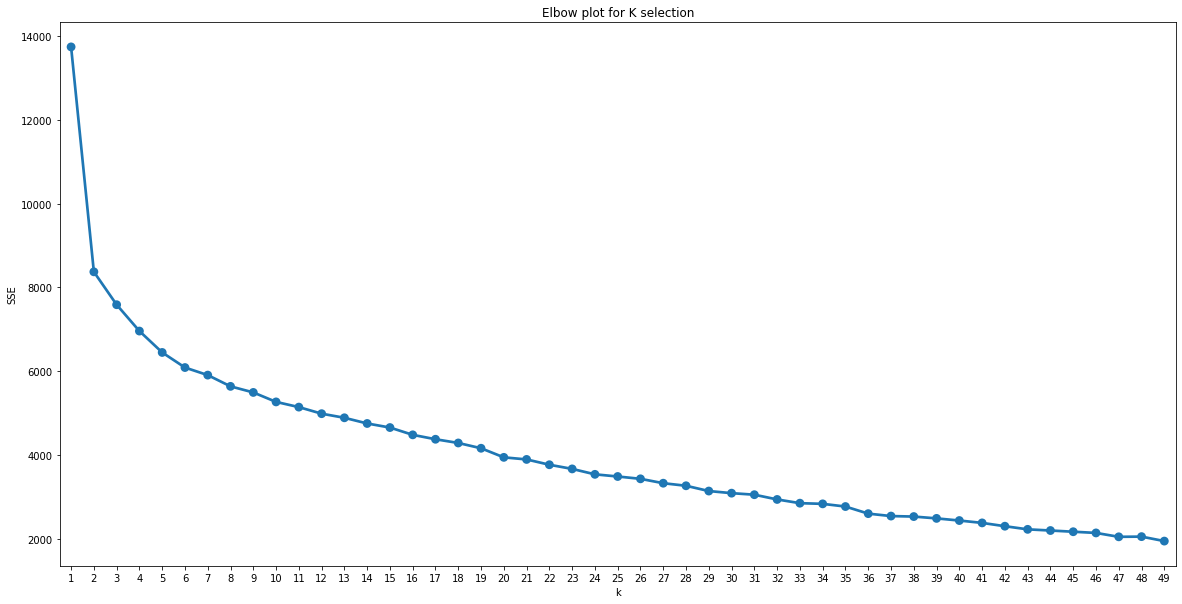

Optimal number of clusters: 8


In [354]:
from kneed import KneeLocator
import seaborn as sns
import matplotlib.pyplot as plt

def elbow_plot(df):
    """Create elbow plot from data"""
    
    sse = {}
    
    for k in range(1, 50):
        kmeans = KMeans(n_clusters=k, random_state=434)
        kmeans.fit(df)
        sse[k] = kmeans.inertia_
        
    plt.rcParams["figure.figsize"] = (20,10)
    plt.title('Elbow plot for K selection')
    plt.xlabel('k')
    plt.ylabel('SSE')
    sns.pointplot(x=list(sse.keys()),
                 y=list(sse.values()))
    plt.show()

    kn = KneeLocator(x=list(sse.keys()), 
                 y=list(sse.values()), 
                 curve='convex', 
                 direction='decreasing')
    k = kn.knee
    return k
    
best_k = elbow_plot(node2vec_output)
print(f"Optimal number of clusters: {best_k}")

In [355]:
kmeans = KMeans(n_clusters=8, random_state=434)
kmeans.fit(node2vec_output)
labels = kmeans.labels_

In [356]:
labels

array([7, 7, 7, ..., 7, 5, 5], dtype=int32)

In [357]:
node2vec_output["labels"] = labels

In [358]:
node2vec_output

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,labels
#hawkerculturesg,0.231724,-0.438408,0.085082,-0.044601,-0.161880,0.230221,-0.312048,0.522622,-0.014925,-0.007604,...,0.369819,-0.230521,0.176492,0.159377,-0.010545,0.514533,-0.217079,-0.077357,-0.193533,7
#hawkerfood,-0.087568,-0.358053,-0.758197,-0.267679,0.033623,0.413672,0.316812,0.782221,0.278285,-0.142948,...,0.470201,0.184882,0.116649,-0.256050,0.406531,0.638809,-0.331956,0.753280,-0.195123,7
#sgfood,0.201582,-0.760565,-0.631205,0.026616,0.236416,0.332584,-0.269419,0.224787,-0.347207,0.026237,...,1.018802,-0.504003,0.218506,0.108897,0.684023,-0.192418,0.369810,0.522200,-0.512197,7
#hawkerfoodsg,0.234289,-0.418587,-1.145511,-0.395781,0.274420,-0.076992,0.007005,0.231066,-0.112920,-0.646784,...,0.690799,-0.525070,0.188455,0.020390,0.297954,0.663459,0.115622,0.602854,-0.552952,7
#hawkerculture,0.903687,-0.579991,-0.566129,-0.519868,0.714406,-0.034764,-0.112108,0.392918,0.003182,-0.079409,...,0.224258,-0.494966,-0.326256,0.673653,0.076890,0.897546,-0.079822,0.220579,0.141154,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
#donburi,-0.124649,-0.110425,0.102686,-0.100214,0.149678,0.015962,-0.335696,0.433864,-0.026910,-0.245476,...,0.911895,-0.552029,0.207881,0.158411,0.084018,-0.342830,0.303406,0.142031,-0.060186,5
#jurongpoint,0.135279,0.253842,0.020803,0.144889,-0.076419,-0.069084,-0.115464,1.000552,0.340592,0.017009,...,0.044693,-0.093934,0.074682,0.227115,-0.019293,0.552050,0.285809,0.337756,0.182938,5
#veg_littledragon,0.446218,-0.233135,0.001591,-1.023076,-0.260733,-0.338440,-0.340911,0.538603,0.317904,0.515169,...,1.112406,-0.117533,0.055184,-0.390496,0.004698,-0.082096,-0.106813,-0.137916,-0.379700,7
#boonlayplace,0.127608,-0.002456,0.114164,0.105075,-0.027901,0.003161,-0.103483,0.698350,0.222533,0.033213,...,0.043968,-0.066202,0.082122,0.510892,0.120980,0.391795,0.387899,0.302420,-0.075724,5


## Filter average likes

In [359]:
new_labels = []
hashtags = list(node2vec_output.index)
labels_list = node2vec_output["labels"].to_list()

In [360]:
for index,hashtag in enumerate(hashtags):
    label = labels_list[index]
    if hashtag_avg_likes_dict[hashtag] < 30:
        new_labels.append(-1)
    else:
        new_labels.append(label)

In [361]:
node2vec_output["labels"] = new_labels

In [362]:
node2vec_output

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,labels
#hawkerculturesg,0.231724,-0.438408,0.085082,-0.044601,-0.161880,0.230221,-0.312048,0.522622,-0.014925,-0.007604,...,0.369819,-0.230521,0.176492,0.159377,-0.010545,0.514533,-0.217079,-0.077357,-0.193533,7
#hawkerfood,-0.087568,-0.358053,-0.758197,-0.267679,0.033623,0.413672,0.316812,0.782221,0.278285,-0.142948,...,0.470201,0.184882,0.116649,-0.256050,0.406531,0.638809,-0.331956,0.753280,-0.195123,7
#sgfood,0.201582,-0.760565,-0.631205,0.026616,0.236416,0.332584,-0.269419,0.224787,-0.347207,0.026237,...,1.018802,-0.504003,0.218506,0.108897,0.684023,-0.192418,0.369810,0.522200,-0.512197,7
#hawkerfoodsg,0.234289,-0.418587,-1.145511,-0.395781,0.274420,-0.076992,0.007005,0.231066,-0.112920,-0.646784,...,0.690799,-0.525070,0.188455,0.020390,0.297954,0.663459,0.115622,0.602854,-0.552952,7
#hawkerculture,0.903687,-0.579991,-0.566129,-0.519868,0.714406,-0.034764,-0.112108,0.392918,0.003182,-0.079409,...,0.224258,-0.494966,-0.326256,0.673653,0.076890,0.897546,-0.079822,0.220579,0.141154,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
#donburi,-0.124649,-0.110425,0.102686,-0.100214,0.149678,0.015962,-0.335696,0.433864,-0.026910,-0.245476,...,0.911895,-0.552029,0.207881,0.158411,0.084018,-0.342830,0.303406,0.142031,-0.060186,-1
#jurongpoint,0.135279,0.253842,0.020803,0.144889,-0.076419,-0.069084,-0.115464,1.000552,0.340592,0.017009,...,0.044693,-0.093934,0.074682,0.227115,-0.019293,0.552050,0.285809,0.337756,0.182938,-1
#veg_littledragon,0.446218,-0.233135,0.001591,-1.023076,-0.260733,-0.338440,-0.340911,0.538603,0.317904,0.515169,...,1.112406,-0.117533,0.055184,-0.390496,0.004698,-0.082096,-0.106813,-0.137916,-0.379700,7
#boonlayplace,0.127608,-0.002456,0.114164,0.105075,-0.027901,0.003161,-0.103483,0.698350,0.222533,0.033213,...,0.043968,-0.066202,0.082122,0.510892,0.120980,0.391795,0.387899,0.302420,-0.075724,-1


In [363]:
node2vec_output["labels"].value_counts()

-1    460
 7    288
 4    163
 6    125
 0    107
 2     43
 3     32
 1     29
Name: labels, dtype: int64

## Visualize

In [364]:
node2vec_output

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,labels
#hawkerculturesg,0.231724,-0.438408,0.085082,-0.044601,-0.161880,0.230221,-0.312048,0.522622,-0.014925,-0.007604,...,0.369819,-0.230521,0.176492,0.159377,-0.010545,0.514533,-0.217079,-0.077357,-0.193533,7
#hawkerfood,-0.087568,-0.358053,-0.758197,-0.267679,0.033623,0.413672,0.316812,0.782221,0.278285,-0.142948,...,0.470201,0.184882,0.116649,-0.256050,0.406531,0.638809,-0.331956,0.753280,-0.195123,7
#sgfood,0.201582,-0.760565,-0.631205,0.026616,0.236416,0.332584,-0.269419,0.224787,-0.347207,0.026237,...,1.018802,-0.504003,0.218506,0.108897,0.684023,-0.192418,0.369810,0.522200,-0.512197,7
#hawkerfoodsg,0.234289,-0.418587,-1.145511,-0.395781,0.274420,-0.076992,0.007005,0.231066,-0.112920,-0.646784,...,0.690799,-0.525070,0.188455,0.020390,0.297954,0.663459,0.115622,0.602854,-0.552952,7
#hawkerculture,0.903687,-0.579991,-0.566129,-0.519868,0.714406,-0.034764,-0.112108,0.392918,0.003182,-0.079409,...,0.224258,-0.494966,-0.326256,0.673653,0.076890,0.897546,-0.079822,0.220579,0.141154,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
#donburi,-0.124649,-0.110425,0.102686,-0.100214,0.149678,0.015962,-0.335696,0.433864,-0.026910,-0.245476,...,0.911895,-0.552029,0.207881,0.158411,0.084018,-0.342830,0.303406,0.142031,-0.060186,-1
#jurongpoint,0.135279,0.253842,0.020803,0.144889,-0.076419,-0.069084,-0.115464,1.000552,0.340592,0.017009,...,0.044693,-0.093934,0.074682,0.227115,-0.019293,0.552050,0.285809,0.337756,0.182938,-1
#veg_littledragon,0.446218,-0.233135,0.001591,-1.023076,-0.260733,-0.338440,-0.340911,0.538603,0.317904,0.515169,...,1.112406,-0.117533,0.055184,-0.390496,0.004698,-0.082096,-0.106813,-0.137916,-0.379700,7
#boonlayplace,0.127608,-0.002456,0.114164,0.105075,-0.027901,0.003161,-0.103483,0.698350,0.222533,0.033213,...,0.043968,-0.066202,0.082122,0.510892,0.120980,0.391795,0.387899,0.302420,-0.075724,-1


In [365]:
data_subset = node2vec_output.drop('labels', 1)

/tmp/ipykernel_258/439335830.py:1: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



In [366]:
data_subset

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
#hawkerculturesg,0.231724,-0.438408,0.085082,-0.044601,-0.161880,0.230221,-0.312048,0.522622,-0.014925,-0.007604,0.310229,0.369819,-0.230521,0.176492,0.159377,-0.010545,0.514533,-0.217079,-0.077357,-0.193533
#hawkerfood,-0.087568,-0.358053,-0.758197,-0.267679,0.033623,0.413672,0.316812,0.782221,0.278285,-0.142948,0.200718,0.470201,0.184882,0.116649,-0.256050,0.406531,0.638809,-0.331956,0.753280,-0.195123
#sgfood,0.201582,-0.760565,-0.631205,0.026616,0.236416,0.332584,-0.269419,0.224787,-0.347207,0.026237,0.618476,1.018802,-0.504003,0.218506,0.108897,0.684023,-0.192418,0.369810,0.522200,-0.512197
#hawkerfoodsg,0.234289,-0.418587,-1.145511,-0.395781,0.274420,-0.076992,0.007005,0.231066,-0.112920,-0.646784,0.747784,0.690799,-0.525070,0.188455,0.020390,0.297954,0.663459,0.115622,0.602854,-0.552952
#hawkerculture,0.903687,-0.579991,-0.566129,-0.519868,0.714406,-0.034764,-0.112108,0.392918,0.003182,-0.079409,-0.491818,0.224258,-0.494966,-0.326256,0.673653,0.076890,0.897546,-0.079822,0.220579,0.141154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
#donburi,-0.124649,-0.110425,0.102686,-0.100214,0.149678,0.015962,-0.335696,0.433864,-0.026910,-0.245476,0.086766,0.911895,-0.552029,0.207881,0.158411,0.084018,-0.342830,0.303406,0.142031,-0.060186
#jurongpoint,0.135279,0.253842,0.020803,0.144889,-0.076419,-0.069084,-0.115464,1.000552,0.340592,0.017009,0.442484,0.044693,-0.093934,0.074682,0.227115,-0.019293,0.552050,0.285809,0.337756,0.182938
#veg_littledragon,0.446218,-0.233135,0.001591,-1.023076,-0.260733,-0.338440,-0.340911,0.538603,0.317904,0.515169,0.389587,1.112406,-0.117533,0.055184,-0.390496,0.004698,-0.082096,-0.106813,-0.137916,-0.379700
#boonlayplace,0.127608,-0.002456,0.114164,0.105075,-0.027901,0.003161,-0.103483,0.698350,0.222533,0.033213,0.252701,0.043968,-0.066202,0.082122,0.510892,0.120980,0.391795,0.387899,0.302420,-0.075724


In [367]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, random_state=434)
tsne_results = tsne.fit_transform(data_subset)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1247 samples in 0.001s...
[t-SNE] Computed neighbors for 1247 samples in 0.048s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1247
[t-SNE] Computed conditional probabilities for sample 1247 / 1247
[t-SNE] Mean sigma: 0.791805
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.901459
[t-SNE] KL divergence after 300 iterations: 0.621208


In [368]:
tsne_2d_one = tsne_results[:,0]
tsne_2d_two = tsne_results[:,1]

In [369]:
hashtags_list = list(node2vec_output.index)
labels = node2vec_output["labels"].to_list()

In [370]:
visualization_df = pd.DataFrame()

In [371]:
visualization_df["one_d"] = tsne_2d_one
visualization_df["two_d"] = tsne_2d_two
visualization_df["label"] = labels
visualization_df["hashtags"] = hashtags_list

In [372]:
visualization_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1247 entries, 0 to 1246
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   one_d     1247 non-null   float32
 1   two_d     1247 non-null   float32
 2   label     1247 non-null   int64  
 3   hashtags  1247 non-null   object 
dtypes: float32(2), int64(1), object(1)
memory usage: 29.4+ KB


In [373]:
def num_to_string(num):
    return str(num)
visualization_df["label"] = visualization_df["label"].apply(num_to_string) 

In [374]:
average_likes = []
for _,row in visualization_df.iterrows():
    hashtag = row["hashtags"]
    try:
        if int(hashtag_avg_likes_dict[hashtag])<1:
            average_likes.append(1)
        else:
            average_likes.append(int(hashtag_avg_likes_dict[hashtag]))
    except:
        average_likes.append(1)
visualization_df["average_likes"] = average_likes

In [375]:
visualization_df["label"].value_counts()

-1    460
7     288
4     163
6     125
0     107
2      43
3      32
1      29
Name: label, dtype: int64

In [376]:
df = px.data.iris()
fig = px.scatter(visualization_df, x="one_d", y="two_d", color="label",
                 size='average_likes', hover_data=["hashtags"])
fig.show()